# Stock Price Prediction for CSCO and AMZN Using LSTM

### Penulis: Felicia Andrea Tandoko

Project ini bertujuan untuk memprediksi harga penutupan saham harian dari dua perusahaan teknologi besar, Cisco Systems (CSCO) dan Amazon.com (AMZN), menggunakan model Long Short-Term Memory (LSTM). Dataset yang digunakan merupakan data historis harga saham harian yang diambil dari Yahoo Finance melalui paket Python “yfinance” hingga 1 April 2020.

Dataset ini mencakup informasi penting seperti harga pembukaan (Open), harga tertinggi (High), harga terendah (Low), harga penutupan (Close), harga penutupan yang disesuaikan (Adj Close), dan volume perdagangan harian (Volume). Namun, dalam proyek ini, fokusnya hanya pada kolom Date dan Close untuk membangun model prediksi.

## **IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## **READ AND EXPLORE DATA**

In [2]:
amzn = pd.read_csv('AMZN.csv')
csco = pd.read_csv('CSCO.csv')

In [3]:
amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [4]:
csco.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1,1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
2,1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
3,1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
4,1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


Pertama, saya memulai dengan eksplorasi data untuk dua dataset ini: AMZN (Amazon) dan CSCO (Cisco). Kedua dataset ini akan saya proses secara terpisah karena mereka berisi data harga saham dari dua perusahaan yang berbeda.

### Explore AMZN data

In [5]:
amzn.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
amzn.shape

(5758, 7)

Data AMZN ini memiliki 5758 data dengan 7 variabel

In [7]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5758 non-null   object 
 1   Open       5758 non-null   float64
 2   High       5758 non-null   float64
 3   Low        5758 non-null   float64
 4   Close      5758 non-null   float64
 5   Adj Close  5758 non-null   float64
 6   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 315.0+ KB


Selanjutnya, saya melakukan parsing untuk kolom Date. Tujuannya adalah untuk mengonversi kolom Date dari format string menjadi format datetime, sehingga memudahkan manipulasi data berbasis waktu seperti filtering, sorting, dan plotting. Selain itu, saya menjadikan kolom Date sebagai indeks DataFrame agar dapat dengan mudah mengakses data berdasarkan tanggal.

In [8]:
amzn_df = pd.read_csv('AMZN.csv',parse_dates=['Date'],index_col=['Date'])

In [9]:
amzn_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


Sekarang kolom 'Date' sudah menjadi format datetime dan menjadikannya sebagai indeks.

Di sini, saya ingin fokus pada prediksi harga penutupan saham, yang merupakan salah satu informasi paling penting dalam analisis saham. Harga penutupan mencerminkan nilai akhir saham setelah satu hari perdagangan dan sering digunakan dalam analisis teknis dan pembuatan keputusan investasi.

Oleh karena itu, saya hanya akan mengambil dan menggunakan kolom 'Close'

In [10]:
amzn_df = pd.DataFrame(amzn_df['Close'])

In [11]:
amzn_df.head()

,Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


In [12]:
print(amzn_df.describe())

             Close
count  5758.000000
mean    340.417580
std     523.140207
min       1.395833
25%      37.562500
50%      81.599998
75%     334.290001
max    2170.219971


Hasil statistik deskriptif ini memberikan gambaran umum tentang distribusi harga penutupan saham Amazon selama periode yang tercatat. Kita dapat melihat bahwa harga penutupan sangat bervariasi, dengan rata-rata yang cukup tinggi tetapi juga dengan standar deviasi yang besar. Ada peningkatan yang signifikan dalam harga penutupan saham Amazon dari nilai terendah (1.40 USD) ke nilai tertinggi (2170.22 USD), menunjukkan pertumbuhan yang signifikan selama periode tersebut.

In [13]:
amzn_missing_values = amzn_df.isnull().sum()
print(f"Missing values:\n{amzn_missing_values}")

Missing values:
Close    0
dtype: int64


Dataset AMZN ini tidak memiliki missing values, sehingga saya dapat melanjutkan analisis dan model prediksi tanpa perlu menangani missing values.

In [14]:
amzn_start_date = amzn_df.index.min()
amzn_end_date = amzn_df.index.max()
print(f"Start Date: {amzn_start_date}, End Date: {amzn_end_date}")

Start Date: 1997-05-15 00:00:00, End Date: 2020-04-01 00:00:00


Untuk mengetahui rentang tanggal dalam dataset, saya menampilkan tanggal pertama dan terakhir dari kolom Date. Hasilnya adalah dataset mencakup periode waktu yang cukup panjang, mulai dari 15 Mei 1997 hingga 1 April 2020.

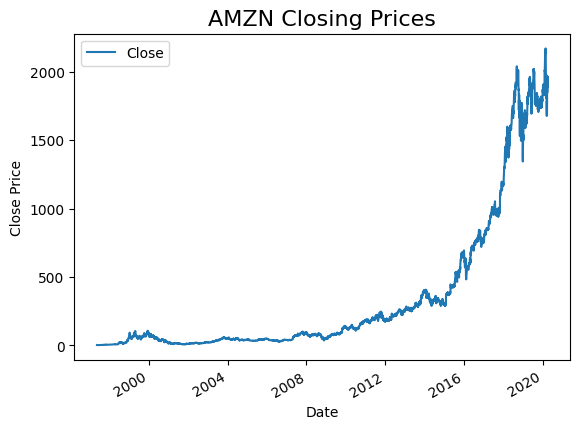

In [15]:
amzn_df.plot()
plt.ylabel("Close Price")
plt.title("AMZN Closing Prices", fontsize=16)
plt.legend()

Plot di atas menampilkan harga penutupan saham Amazon (AMZN) dari 15 Mei 1997 hingga 1 April 2020.

1. Tren Jangka Panjang:

- Harga penutupan saham Amazon menunjukkan tren kenaikan yang signifikan dari tahun 1997 hingga 2020.
Pada awal periode, harga saham relatif rendah dan stabil, tetapi mulai meningkat pesat terutama setelah tahun 2010.

2. Fluktuasi Harga:

- Terdapat beberapa periode volatilitas tinggi di mana harga saham mengalami fluktuasi yang tajam. Hal ini dapat disebabkan oleh berbagai faktor, termasuk laporan pendapatan, perubahan pasar, dan berita perusahaan.

3. Pertumbuhan Eksponensial:
- Dari tahun 2015 ke atas, harga saham Amazon menunjukkan pertumbuhan eksponensial, mencerminkan peningkatan nilai perusahaan secara signifikan.

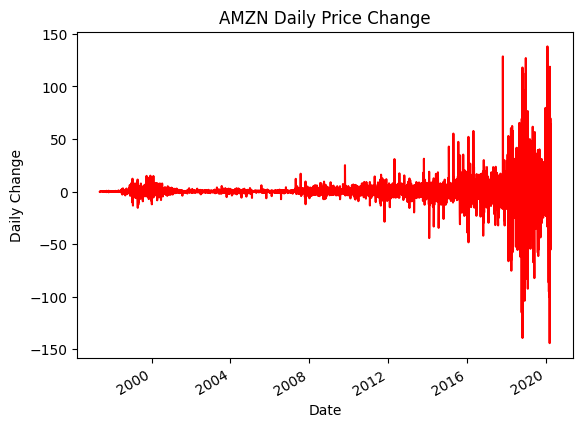

In [16]:
amzn_df['Daily Change'] = amzn_df['Close'].diff()
amzn_df['Daily Change'].plot(color='red')
plt.xlabel('Date')
plt.ylabel('Daily Change')
plt.title('AMZN Daily Price Change')
plt.show()

Plot di atas menampilkan perubahan harga harian saham Amazon (AMZN) dari 15 Mei 1997 hingga 1 April 2020. Visualisasi ini dibuat untuk memahami volatilitas harian dari saham Amazon.

1. Tren Perubahan Harian:

- Pada awal periode (sekitar tahun 2000), perubahan harga harian relatif kecil dan stabil.
Seiring waktu, terutama setelah tahun 2010, perubahan harga harian menjadi semakin besar dan lebih volatil.

2. Volatilitas Tinggi:
- Terlihat bahwa setelah tahun 2015, perubahan harga harian menunjukkan fluktuasi yang signifikan. Ini bisa mencerminkan peningkatan volume perdagangan, lebih banyak perhatian dari investor, dan reaksi terhadap berita atau laporan pendapatan.

3. Perubahan Ekstrem:
- Ada beberapa puncak dan lembah tajam yang menunjukkan perubahan harga yang sangat signifikan dalam satu hari. Hal ini bisa terjadi karena pengumuman besar atau kejadian pasar yang memengaruhi harga saham secara dramatis.

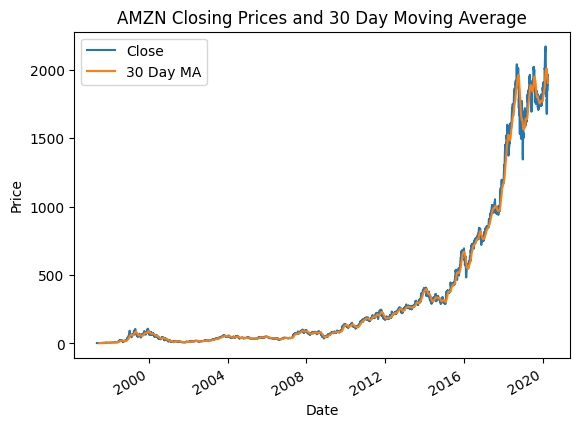

In [17]:
amzn_df['30 Day MA'] = amzn_df['Close'].rolling(window=30).mean()
amzn_df[['Close', '30 Day MA']].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AMZN Closing Prices and 30 Day Moving Average')
plt.show()

Plot di atas menampilkan harga penutupan saham Amazon (AMZN) dan rata-rata bergerak 30 hari (30 Day Moving Average) dari 15 Mei 1997 hingga 1 April 2020.

1. Harga Penutupan:
- Harga penutupan saham Amazon menunjukkan tren naik yang signifikan dari tahun 1997 hingga 2020.
Terlihat jelas bahwa ada pertumbuhan yang eksponensial terutama setelah tahun 2010.

2. Rata-Rata Bergerak 30 Hari:
- Garis rata-rata bergerak 30 hari (30 Day MA) mengikuti tren harga penutupan tetapi lebih halus, karena rata-rata bergerak mengurangi fluktuasi jangka pendek dan memberikan pandangan yang lebih jelas tentang tren jangka panjang.
Rata-rata bergerak ini membantu dalam mengidentifikasi tren yang lebih stabil dan mengurangi efek volatilitas harian.

3. Perbandingan:
- Saat harga penutupan berada di atas rata-rata bergerak, ini sering kali menunjukkan tren naik.
Sebaliknya, ketika harga penutupan berada di bawah rata-rata bergerak, ini bisa menunjukkan potensi pembalikan tren atau periode penurunan.

Sebelum masuk ke modelling dan traininng, saya mengonversi kolom Date dan Close dari DataFrame menjadi array numpy. Alasannya adalah karena:
- Banyak algoritma machine learning atau deep learning dan fungsi di PyTorch memerlukan input dalam bentuk array numpy atau tensor PyTorch. Konversi ini membuat data siap untuk digunakan dalam model.
- Operasi pada array numpy biasanya lebih cepat dibandingkan dengan operasi pada kolom DataFrame pandas, terutama untuk operasi numerik yang intensif.
Kemudahan Manipulasi Data:
- Array numpy memudahkan manipulasi data seperti reshaping, slicing, dan agregasi, yang diperlukan untuk membentuk dataset yang sesuai untuk pelatihan model LSTM.


In [18]:
timesteps_amzn = amzn_df.index.to_numpy()
close_amzn = amzn_df["Close"].to_numpy()

timesteps_amzn[:10], close_amzn[:10]

(array(['1997-05-15T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
        '1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', '1997-05-27T00:00:00.000000000',
        '1997-05-28T00:00:00.000000000', '1997-05-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
        1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

### Windowizing AMZN data

Selanjutnya, saya melakukan windowizing dengan ketentuan window_size=5 dan horizon_size=1. Windowizing adalah proses memecah data time series menjadi sekumpulan window data untuk digunakan sebagai input dan output dalam model prediksi. Dalam hal ini, setiap window terdiri dari 5 nilai berturut-turut sebagai input, dan nilai berikutnya sebagai output. Pendekatan ini membantu model belajar dari pola jangka pendek dalam data time series dan membuat prediksi yang lebih akurat.

In [19]:
def create_dataset(data, window_size=5, horizon_size=1):
  x, y = [], []
  for i in range(len(data) - window_size - horizon_size + 1):
    window = data[i:i + window_size]
    horizon = data[i + window_size + horizon_size - 1]
    x.append(window)
    y.append(horizon)

  return np.array(x), np.array(y)

In [20]:
amzn_x, amzn_y = create_dataset(close_amzn)

In [21]:
len(amzn_x), len(amzn_y)

(5753, 5753)

Contoh hasil windowizing:

In [22]:
for i in range(3):
  print(f"Window: {amzn_x[i]} -> Label: {amzn_y[i]}")

Window: [1.95833337 1.72916663 1.70833337 1.63541663 1.42708337] -> Label: 1.3958333730697632
Window: [1.72916663 1.70833337 1.63541663 1.42708337 1.39583337] -> Label: 1.5
Window: [1.70833337 1.63541663 1.42708337 1.39583337 1.5       ] -> Label: 1.5833333730697632


Check bahwa hasil windowizingnya benar

In [23]:
close_amzn[:6]

array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
       1.39583337])

In [24]:
close_amzn[1:7]

array([1.72916663, 1.70833337, 1.63541663, 1.42708337, 1.39583337,
       1.5       ])

In [25]:
close_amzn[2:8]

array([1.70833337, 1.63541663, 1.42708337, 1.39583337, 1.5       ,
       1.58333337])

### Splitting AMZN data

Selanjutnya, saya membagi data menjadi tiga set: 80% untuk pelatihan (training), 10% untuk validasi (validation), dan 10% untuk pengujian (test). Dalam data time series, pembagian data harus dilakukan berdasarkan urutan waktu, bukan secara acak (random splitting).

In [26]:
split_size = int(0.8 * len(amzn_x))
val_split_size = int(0.1 * len(amzn_x))

amzn_x_train, amzn_y_train = amzn_x[:split_size], amzn_y[:split_size]
amzn_x_val, amzn_y_val = amzn_x[split_size:split_size + val_split_size], amzn_y[split_size:split_size + val_split_size]
amzn_x_test, amzn_y_test = amzn_x[split_size + val_split_size:], amzn_y[split_size + val_split_size:]

len(amzn_x_train), len(amzn_x_val), len(amzn_x_test), len(amzn_y_train), len(amzn_y_val), len(amzn_y_test)

(4602, 575, 576, 4602, 575, 576)

In [27]:
window_size = 5
horizon_size = 1
dates_adjusted = timesteps_amzn[window_size + horizon_size - 2:]

dates_train = dates_adjusted[:split_size]
dates_val = dates_adjusted[split_size:split_size + val_split_size]
dates_test = dates_adjusted[split_size + val_split_size:]

print("Train data range: {} to {}".format(dates_train[0], dates_train[-1]))
print("Validation data range: {} to {}".format(dates_val[0], dates_val[-1]))
print("Test data range: {} to {}".format(dates_test[0], dates_test[-1]))

Train data range: 1997-05-21T00:00:00.000000000 to 2015-09-02T00:00:00.000000000
Validation data range: 2015-09-03T00:00:00.000000000 to 2017-12-13T00:00:00.000000000
Test data range: 2017-12-14T00:00:00.000000000 to 2020-04-01T00:00:00.000000000


### Explore CSCO data

Sekarang saya akan explore CSCO data dengan cara yang sama seperti explore AMZN data. Jadi, saya tidak akan menjelasakan setiap proses secara lengkap.

In [28]:
csco.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [29]:
csco.shape

(7589, 7)

Data CSCO ini memiliki 7589 data dengan 7 variabel

In [30]:
csco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7589 non-null   object 
 1   Open       7589 non-null   float64
 2   High       7589 non-null   float64
 3   Low        7589 non-null   float64
 4   Close      7589 non-null   float64
 5   Adj Close  7589 non-null   float64
 6   Volume     7589 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 415.1+ KB


Parsing untuk kolom Date.

In [31]:
csco_df = pd.read_csv('CSCO.csv',parse_dates=['Date'],index_col=['Date'])

In [32]:
csco_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


In [33]:
csco_df = pd.DataFrame(csco_df['Close'])

In [34]:
csco_df.head()

,Close
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


In [35]:
print(csco_df.describe())

             Close
count  7589.000000
mean     20.399541
std      14.906589
min       0.071181
25%       8.479167
50%      19.680000
75%      27.120001
max      80.062500


In [36]:
csco_missing_values = csco_df.isnull().sum()
print(f"Missing values:\n{csco_missing_values}")

Missing values:
Close    0
dtype: int64


Dataset CSCO ini tidak memiliki missing values.

In [37]:
csco_start_date = amzn_df.index.min()
csco_end_date = amzn_df.index.max()
print(f"Start Date: {csco_start_date}, End Date: {csco_end_date}")

Start Date: 1997-05-15 00:00:00, End Date: 2020-04-01 00:00:00


Dataset mencakup periode waktu yang cukup panjang, mulai dari 15 Mei 1997 hingga 1 April 2020.

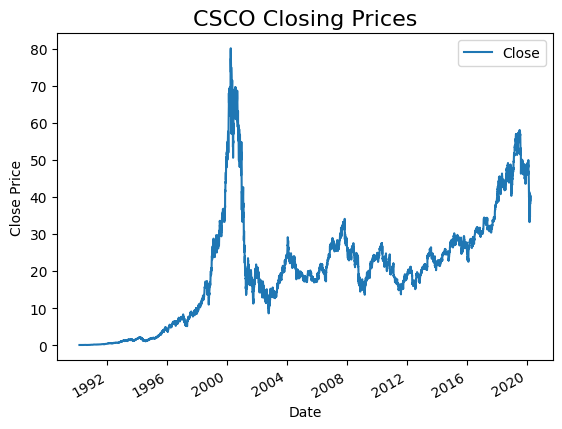

In [38]:
csco_df.plot()
plt.ylabel("Close Price")
plt.title("CSCO Closing Prices", fontsize=16)
plt.legend()

Plot di atas menampilkan harga penutupan saham Cisco Systems, Inc. (CSCO) dari awal periode yang tersedia hingga 2020.

1. Tren Jangka Panjang:
- Harga penutupan saham Cisco menunjukkan peningkatan yang signifikan hingga puncaknya sekitar tahun 2000.
Setelah tahun 2000, terdapat penurunan tajam yang kemungkinan disebabkan oleh gelembung dot-com.

2. Volatilitas:
- Terlihat volatilitas tinggi sekitar tahun 2000, yang diikuti oleh periode volatilitas yang lebih rendah tetapi tetap signifikan.
Harga saham tampaknya lebih stabil setelah tahun 2004, tetapi masih menunjukkan fluktuasi yang cukup besar.

3. Pertumbuhan Kembali:
- Setelah penurunan awal 2000-an, harga saham Cisco mengalami pertumbuhan kembali, terutama terlihat dari 2010 hingga 2020.

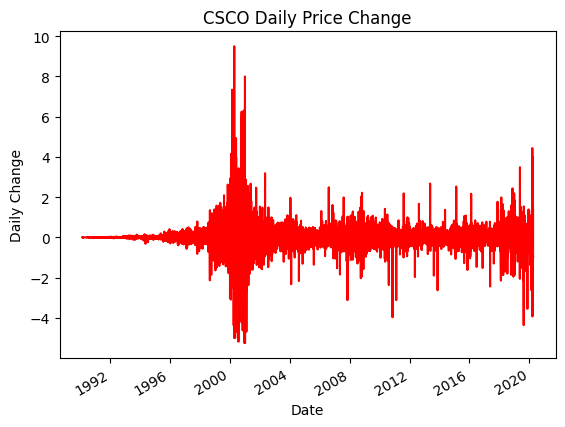

In [39]:
csco_df['Daily Change'] = csco_df['Close'].diff()
csco_df['Daily Change'].plot(color='red')
plt.xlabel('Date')
plt.ylabel('Daily Change')
plt.title('CSCO Daily Price Change')
plt.show()

Plot di atas menampilkan perubahan harga harian saham Cisco Systems, Inc. (CSCO) dari awal periode yang tersedia hingga 2020.

1. Tren Perubahan Harian:
- Pada awal periode, perubahan harga harian relatif kecil dan stabil.
Sekitar tahun 2000, terjadi peningkatan volatilitas dengan perubahan harga harian yang sangat signifikan, baik naik maupun turun. Ini mungkin terkait dengan gelembung dot-com.

2. Volatilitas:
- Setelah tahun 2000, volatilitas tetap tinggi selama beberapa tahun tetapi mulai stabil setelah 2004.
Perubahan harga harian tetap cukup fluktuatif hingga 2020, menunjukkan bahwa saham Cisco masih mengalami volatilitas yang signifikan.

3. Perubahan Ekstrem:
- Ada beberapa puncak dan lembah tajam yang menunjukkan perubahan harga yang sangat besar dalam satu hari. Ini bisa terjadi karena berbagai faktor seperti laporan pendapatan, berita besar, atau peristiwa pasar.

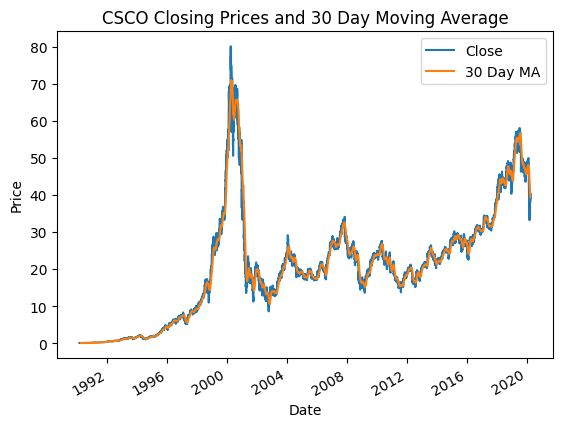

In [40]:
csco_df['30 Day MA'] = csco_df['Close'].rolling(window=30).mean()
csco_df[['Close', '30 Day MA']].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('CSCO Closing Prices and 30 Day Moving Average')
plt.show()

Plot di atas menampilkan harga penutupan saham Cisco Systems, Inc. (CSCO) dan rata-rata bergerak 30 hari (30 Day Moving Average) dari awal periode yang tersedia hingga 2020.

1. Harga Penutupan:
- Harga penutupan saham Cisco menunjukkan tren naik yang signifikan hingga puncaknya sekitar tahun 2000.
Setelah puncak tersebut, harga saham mengalami penurunan tajam dan kemudian fluktuasi dengan pola yang lebih stabil setelah tahun 2004.

2. Rata-Rata Bergerak 30 Hari:
- Garis rata-rata bergerak 30 hari mengikuti tren harga penutupan tetapi lebih halus, karena rata-rata bergerak mengurangi fluktuasi jangka pendek dan memberikan pandangan yang lebih jelas tentang tren jangka panjang.
Rata-rata bergerak ini membantu dalam mengidentifikasi tren yang lebih stabil dan mengurangi efek volatilitas harian.

3. Perbandingan:
- Ketika harga penutupan berada di atas rata-rata bergerak, ini sering kali menunjukkan tren naik.
Sebaliknya, ketika harga penutupan berada di bawah rata-rata bergerak, ini bisa menunjukkan potensi pembalikan tren atau periode penurunan.

Mengonversi kolom Date dan Close dari DataFrame menjadi array numpy.

In [41]:
timesteps_csco = csco_df.index.to_numpy()
close_csco = csco_df["Close"].to_numpy()

timesteps_csco[:10], close_csco[:10]

(array(['1990-02-16T00:00:00.000000000', '1990-02-20T00:00:00.000000000',
        '1990-02-21T00:00:00.000000000', '1990-02-22T00:00:00.000000000',
        '1990-02-23T00:00:00.000000000', '1990-02-26T00:00:00.000000000',
        '1990-02-27T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
        '1990-03-01T00:00:00.000000000', '1990-03-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
        0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

### Windowizing CSCO data

Windowizing dengan ketentuan window_size=5 dan horizon_size=1

In [42]:
csco_x, csco_y = create_dataset(close_csco)

In [43]:
len(csco_x), len(csco_y)

(7584, 7584)

Contoh hasil windowizing:

In [44]:
for i in range(3):
  print(f"Window: {csco_x[i]} -> Label: {csco_y[i]}")

Window: [0.07725695 0.07986111 0.078125   0.07899305 0.07855903] -> Label: 0.0763888880610466
Window: [0.07986111 0.078125   0.07899305 0.07855903 0.07638889] -> Label: 0.078125
Window: [0.078125   0.07899305 0.07855903 0.07638889 0.078125  ] -> Label: 0.0807291641831398


Check bahwa hasil windowizing benar

In [45]:
close_csco[:6]

array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
       0.07638889])

In [46]:
close_amzn[1:7]

array([1.72916663, 1.70833337, 1.63541663, 1.42708337, 1.39583337,
       1.5       ])

In [47]:
close_amzn[2:8]

array([1.70833337, 1.63541663, 1.42708337, 1.39583337, 1.5       ,
       1.58333337])

### Splitting CSCO data into train, val, test

Membagi data menjadi tiga set: 80% untuk pelatihan (training), 10% untuk validasi (validation), dan 10% untuk pengujian (test) berdasarkan urutan waktu.

In [48]:
split_size = int(0.8 * len(csco_x))
val_split_size = int(0.1 * len(csco_x))

csco_x_train, csco_y_train = csco_x[:split_size], csco_y[:split_size]
csco_x_val, csco_y_val = csco_x[split_size:split_size + val_split_size], csco_y[split_size:split_size + val_split_size]
csco_x_test, csco_y_test = csco_x[split_size + val_split_size:], csco_y[split_size + val_split_size:]

len(csco_x_train), len(csco_x_val), len(csco_x_test), len(csco_y_train), len(csco_y_val), len(csco_y_test)

(6067, 758, 759, 6067, 758, 759)

In [49]:
window_size = 5
horizon_size = 1
dates_adjusted = timesteps_csco[window_size + horizon_size - 2:]

dates_train = dates_adjusted[:split_size]
dates_val = dates_adjusted[split_size:split_size + val_split_size]
dates_test = dates_adjusted[split_size + val_split_size:]

print("Train data range: {} to {}".format(dates_train[0], dates_train[-1]))
print("Validation data range: {} to {}".format(dates_val[0], dates_val[-1]))
print("Test data range: {} to {}".format(dates_test[0], dates_test[-1]))

Train data range: 1990-02-23T00:00:00.000000000 to 2014-03-21T00:00:00.000000000
Validation data range: 2014-03-24T00:00:00.000000000 to 2017-03-24T00:00:00.000000000
Test data range: 2017-03-27T00:00:00.000000000 to 2020-04-01T00:00:00.000000000


## **LSTM BASELINE MODEL**

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Saya melakukan konversi ke Tensor dan membuat DataLoader terlebih dahulu

- Konversi ke Tensor: Mengonversi data ke tensor PyTorch agar dapat digunakan oleh model.
- DataLoader: Memudahkan pengelolaan data selama pelatihan, termasuk batching dan pengacakan data.

In [51]:
def prepare_dataloader(X, y, batch_size=32):
    tensor_x = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    tensor_y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [52]:
# DataLoader for AMZN
train_loader_amzn = prepare_dataloader(amzn_x_train, amzn_y_train)
val_loader_amzn = prepare_dataloader(amzn_x_val, amzn_y_val)
test_loader_amzn = prepare_dataloader(amzn_x_test, amzn_y_test)

In [53]:
# DataLoader for CSCO
train_loader_csco = prepare_dataloader(csco_x_train, csco_y_train)
val_loader_csco = prepare_dataloader(csco_x_val, csco_y_val)
test_loader_csco = prepare_dataloader(csco_x_test, csco_y_test)

In [54]:
class BaselineLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaselineLSTMModel, self).__init__()
        self.model = nn.Sequential(
            nn.LSTM(input_size, hidden_size, batch_first=True),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        lstm_out, _ = self.model[0](x)
        relu_out = self.model[1](lstm_out[:, -1, :])
        out = self.model[2](relu_out)
        return out

Arsitektur yang dibuat sesuai dengan permintaan soal mencakup:

- Layer LSTM dengan 50 unit untuk memproses data sequence: Data melewati layer LSTM dengan 50 unit. Layer ini memproses data sequence dan menghasilkan output sequence beserta hidden states.
- Fungsi aktivasi ReLU untuk memperkenalkan non-linearitas: Output dari layer LSTM diteruskan ke fungsi aktivasi ReLU. Fungsi ini hanya membiarkan nilai positif melewatinya, memperkenalkan non-linearitas ke dalam model.
- Layer Dense akhir dengan satu unit untuk menghasilkan prediksi tunggal: Output dari fungsi ReLU kemudian diteruskan ke layer Dense dengan satu unit. Layer ini menghasilkan satu nilai prediksi sebagai output akhir dari model.

Arsitektur ini dirancang untuk menangkap pola kompleks dalam data time series dan menghasilkan prediksi yang akurat, sesuai dengan tujuan tugas regresi pada data harga saham.

In [55]:
input_size = 1
hidden_size = 50
output_size = 1
learning_rate = 0.001
num_epochs = 30

1. input_size = 1:
- Ukuran input adalah 1, karena kita hanya menggunakan satu fitur yaitu harga penutupan saham ('Close').

2. hidden_size = 50:
- Ukuran hidden layer adalah 50, sesuai dengan permintaan soal untuk unit LSTM.

3. output_size = 1:
- Ukuran output adalah 1, karena model menghasilkan satu nilai prediksi (harga penutupan).

4. learning_rate = 0.001:
- Learning rate adalah 0.001, yang mengontrol seberapa besar langkah update parameter model pada setiap iterasi.

5. num_epochs = 30:
- Jumlah epoch adalah 30, yaitu berapa kali seluruh dataset dilalui selama proses pelatihan.

In [56]:
criterion = nn.MSELoss()

baseline_model_amzn = BaselineLSTMModel(input_size, hidden_size, output_size)
baseline_optimizer_amzn = optim.Adam(baseline_model_amzn.parameters(), lr=0.001)

baseline_model_csco = BaselineLSTMModel(input_size, hidden_size, output_size)
baseline_optimizer_csco = optim.Adam(baseline_model_csco.parameters(), lr=0.001)

1. MSELoss (Mean Squared Error Loss): Digunakan sebagai fungsi loss untuk mengukur rata-rata kesalahan kuadrat antara nilai yang diprediksi oleh model dan nilai sebenarnya. Ini adalah fungsi loss yang umum digunakan untuk tugas regresi seperti prediksi harga saham.

2. baseline_model: Membuat instance model baseline LSTM untuk data AMZN dengan parameter input_size, hidden_size, dan output_size yang sudah ditentukan.

3. baseline_optimizer: Membuat optimizer Adam untuk model AMZN dengan learning rate 0.001. Optimizer ini akan mengupdate parameter model untuk meminimalkan loss selama pelatihan.

Sekarang, saya akan melakukan training untuk baseline architecture dengan jumlah epoch 30 dan menerapkan early stopping, yaitu teknik untuk menghentikan pelatihan lebih awal jika kinerja pada set validasi tidak meningkat setelah sejumlah iterasi tertentu. Ini membantu mencegah overfitting.

In [57]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 10
    best_model = model.state_dict()

    train_losses_epoch = []
    val_losses_epoch = []

    for epoch in range(num_epochs):
        train_losses = []
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_losses_epoch.append(train_loss)
        val_losses_epoch.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    model.load_state_dict(best_model)
    return model, train_losses_epoch, val_losses_epoch

In [58]:
print("Training AMZN model")
baseline_model_amzn, train_losses_amzn, val_losses_amzn = train_model(baseline_model_amzn, train_loader_amzn, val_loader_amzn, criterion, baseline_optimizer_amzn, num_epochs)

Training AMZN model
Epoch 1, Train Loss: 24732.6748691135, Val Loss: 652866.7395833334
Epoch 2, Train Loss: 23813.277706570094, Val Loss: 647130.9027777778
Epoch 3, Train Loss: 23099.38872273763, Val Loss: 642088.4340277778
Epoch 4, Train Loss: 22487.550079345703, Val Loss: 637278.0486111111
Epoch 5, Train Loss: 21861.517879909938, Val Loss: 631844.1770833334
Epoch 6, Train Loss: 21148.969451904297, Val Loss: 625410.4826388889
Epoch 7, Train Loss: 20455.205861409504, Val Loss: 619888.6979166666
Epoch 8, Train Loss: 19848.928098890516, Val Loss: 614777.0381944445
Epoch 9, Train Loss: 19281.93168809679, Val Loss: 609580.1666666666
Epoch 10, Train Loss: 18728.80546061198, Val Loss: 604623.1128472222
Epoch 11, Train Loss: 18231.20189751519, Val Loss: 599829.0243055555
Epoch 12, Train Loss: 17735.292037963867, Val Loss: 594847.1979166666
Epoch 13, Train Loss: 17280.711266411676, Val Loss: 590139.3871527778
Epoch 14, Train Loss: 16826.84800720215, Val Loss: 585686.5381944445
Epoch 15, Train 

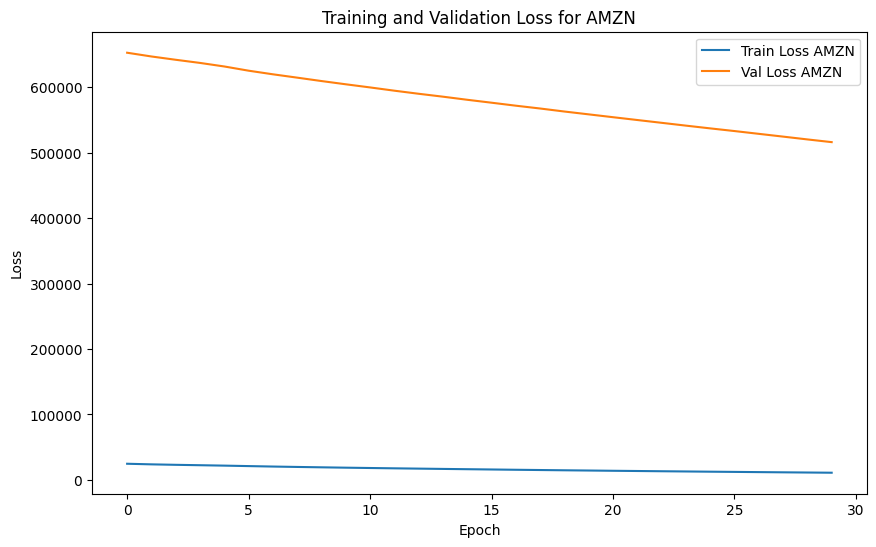

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_amzn, label='Train Loss AMZN')
plt.plot(val_losses_amzn, label='Val Loss AMZN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for AMZN')
plt.legend()
plt.show()

- Train Loss Stabil dan Rendah: Model mampu mempelajari data pelatihan dengan baik.
- Val Loss Tinggi: Menunjukkan adanya overfitting, di mana model tidak generalisasi dengan baik pada data validasi.

In [60]:
print("Training CSCO model")
baseline_model_csco, train_losses_csco, val_losses_csco = train_model(baseline_model_csco, train_loader_csco, val_loader_csco, criterion, baseline_optimizer_csco, num_epochs)

Training CSCO model
Epoch 1, Train Loss: 362.1673051532946, Val Loss: 483.2640609741211
Epoch 2, Train Loss: 247.1510453475149, Val Loss: 331.2281608581543
Epoch 3, Train Loss: 182.73903471294201, Val Loss: 226.80821164449057
Epoch 4, Train Loss: 140.20571620338842, Val Loss: 153.274032274882
Epoch 5, Train Loss: 112.61743681054367, Val Loss: 102.73809750874837
Epoch 6, Train Loss: 94.60080928551524, Val Loss: 67.40049250920613
Epoch 7, Train Loss: 81.54325103634282, Val Loss: 42.2075891494751
Epoch 8, Train Loss: 71.89881305569097, Val Loss: 25.307386716206867
Epoch 9, Train Loss: 64.37270252853632, Val Loss: 14.07147224744161
Epoch 10, Train Loss: 58.279329038842725, Val Loss: 7.023256282011668
Epoch 11, Train Loss: 52.49741574196439, Val Loss: 3.0808983594179153
Epoch 12, Train Loss: 47.5691069466503, Val Loss: 1.235071777055661
Epoch 13, Train Loss: 43.017933091011486, Val Loss: 0.7489041561881701
Epoch 14, Train Loss: 38.77750687379586, Val Loss: 0.24299941025674343
Epoch 15, Trai

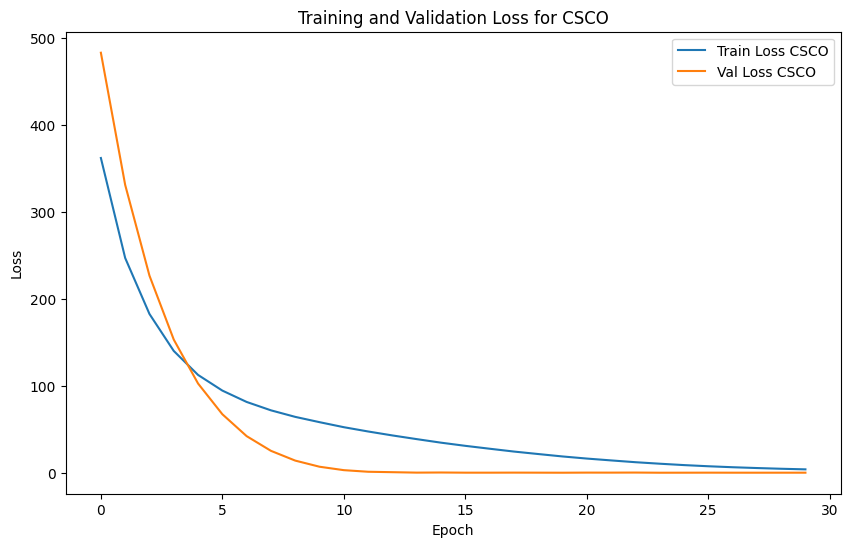

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_csco, label='Train Loss CSCO')
plt.plot(val_losses_csco, label='Val Loss CSCO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for CSCO')
plt.legend()
plt.show()

- Train Loss dan Val Loss Menurun: Model mampu belajar dari data pelatihan dan juga generalisasi dengan baik pada data validasi.
- Tidak Terjadi Overfitting: Karena val loss juga menurun, ini menunjukkan model tidak overfit pada data pelatihan dan bekerja dengan baik pada data yang belum pernah dilihat.

## **LSTM MODIFIED ARCHITECTURE**

Setelah mengevaluasi hasil dari arsitektur baseline, saya melakukan beberapa modifikasi pada arsitektur model LSTM untuk meningkatkan kinerja. Berikut adalah penjelasan dari modifikasi yang dilakukan dan alasan di balik pemilihan pendekatan tersebut.

1. Penambahan Jumlah LSTM Layers:
- Baseline: 1 LSTM layer
- Modified: 2 LSTM layers
- Alasan: Menambah jumlah layer LSTM dapat membantu model menangkap pola yang lebih kompleks dalam data time series. Dengan lebih banyak layer, model dapat belajar fitur yang lebih abstrak dan mendalam dari data.

2. Penambahan Dropout:
- Baseline: Tidak ada dropout
- Modified: Dropout rate 0.2
- Alasan: Dropout adalah teknik regularisasi yang membantu mencegah overfitting dengan mengabaikan sejumlah neuron secara acak selama pelatihan. Ini membantu model generalisasi lebih baik pada data baru.

3. Penambahan Ukuran Hidden Layer:
- Baseline: 50 unit
- Modified: 100 unit
- Alasan: Menambah ukuran hidden layer memungkinkan model untuk menyimpan lebih banyak informasi dan belajar representasi yang lebih kompleks dari data. Ini dapat meningkatkan kemampuan model untuk melakukan prediksi yang lebih akurat.

4. Hyperparameters:
- learning_rate = 0.001: Tetap sama karena ini adalah nilai yang umumnya bekerja baik untuk optimasi Adam.
- num_epochs = 50: Jumlah epoch ditingkatkan dari 30 ke 50 untuk memberi model lebih banyak waktu belajar dan meningkatkan kinerja.
- dropout = 0.2: Menambah dropout untuk regularisasi tambahan.

In [62]:
class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(ModifiedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.relu(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

In [63]:
input_size = 1
hidden_size = 100
output_size = 1
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 50

In [64]:
criterion = nn.MSELoss()

modified_model_amzn = ModifiedLSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
modified_optimizer_amzn = optim.Adam(modified_model_amzn.parameters(), lr=learning_rate)

modified_model_csco = ModifiedLSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
modified_optimizer_csco = optim.Adam(modified_model_csco.parameters(), lr=learning_rate)

In [65]:
print("Training modified AMZN model")
modified_model_amzn, train_losses_amzn_mod, val_losses_amzn_mod = train_model(modified_model_amzn, train_loader_amzn, val_loader_amzn, criterion, modified_optimizer_amzn, num_epochs)

Training modified AMZN model
Epoch 1, Train Loss: 24131.215945773656, Val Loss: 646188.96875
Epoch 2, Train Loss: 22675.18485853407, Val Loss: 635917.8923611111
Epoch 3, Train Loss: 21378.025058322484, Val Loss: 625376.9131944445
Epoch 4, Train Loss: 20181.939770168727, Val Loss: 615457.1076388889
Epoch 5, Train Loss: 19080.40391031901, Val Loss: 604848.4270833334
Epoch 6, Train Loss: 18039.660549587672, Val Loss: 595369.1475694445
Epoch 7, Train Loss: 17077.23486328125, Val Loss: 585785.7170138889
Epoch 8, Train Loss: 16212.199334038629, Val Loss: 576813.0451388889
Epoch 9, Train Loss: 15392.087914360895, Val Loss: 568246.7934027778
Epoch 10, Train Loss: 14636.487940470377, Val Loss: 559555.9427083334
Epoch 11, Train Loss: 13918.97764925162, Val Loss: 551331.0572916666
Epoch 12, Train Loss: 13240.488632202148, Val Loss: 543124.0503472222
Epoch 13, Train Loss: 12581.454567379422, Val Loss: 535180.0642361111
Epoch 14, Train Loss: 11970.31036037869, Val Loss: 527372.296875
Epoch 15, Trai

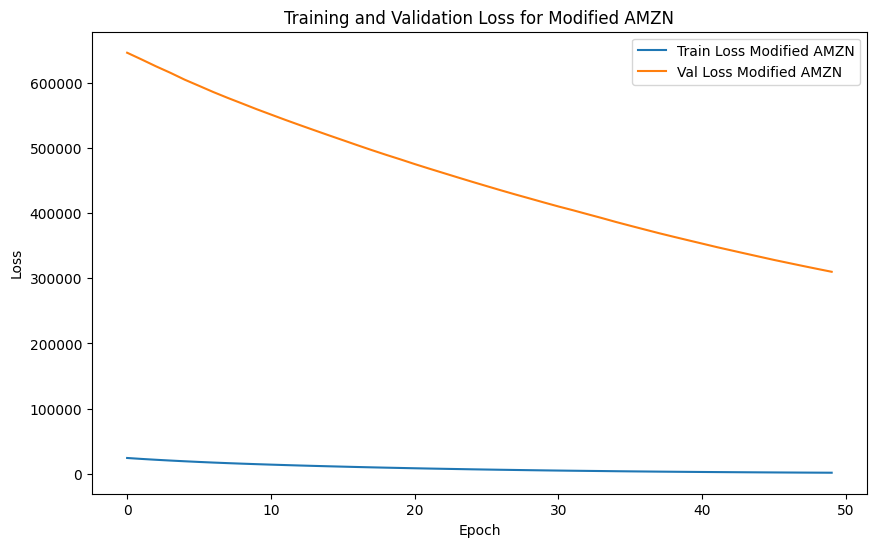

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_amzn_mod, label='Train Loss Modified AMZN')
plt.plot(val_losses_amzn_mod, label='Val Loss Modified AMZN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Modified AMZN')
plt.legend()
plt.show()

- Penurunan yang Konsisten: Kedua garis menunjukkan penurunan yang konsisten, yang menunjukkan bahwa model terus belajar dan memperbaiki kinerjanya baik pada data pelatihan maupun data validasi.
- Val Loss Masih Tinggi: Meskipun ada penurunan, val loss tetap tinggi dibandingkan train loss, yang mengindikasikan adanya overfitting meskipun telah dilakukan beberapa regularisasi dengan dropout.
- Kinerja yang Meningkat: Dibandingkan dengan model baseline, ada peningkatan dalam kinerja model yang dimodifikasi ini, terutama dalam hal penurunan val loss yang lebih signifikan seiring bertambahnya epoch.

In [67]:
print("Training modified CSCO model")
modified_model_csco, train_losses_csco_mod, val_losses_csco_mod = train_model(modified_model_csco, train_loader_csco, val_loader_csco, criterion, modified_optimizer_csco, num_epochs)

Training modified CSCO model
Epoch 1, Train Loss: 302.14842276322213, Val Loss: 342.97885513305664
Epoch 2, Train Loss: 167.98551921844484, Val Loss: 167.1880054473877
Epoch 3, Train Loss: 107.74977794195476, Val Loss: 70.69403092066447
Epoch 4, Train Loss: 77.19739978564412, Val Loss: 23.158691883087158
Epoch 5, Train Loss: 59.507435997261815, Val Loss: 6.14317312836647
Epoch 6, Train Loss: 48.824049346423465, Val Loss: 1.0896113080283005
Epoch 7, Train Loss: 40.38080008559321, Val Loss: 0.23643445068349442
Epoch 8, Train Loss: 33.610080137927284, Val Loss: 0.34498313007255393
Epoch 9, Train Loss: 27.673011098292314, Val Loss: 0.17032920445005098
Epoch 10, Train Loss: 22.542120024169748, Val Loss: 0.27927231912811595
Epoch 11, Train Loss: 18.33971384199042, Val Loss: 0.3868103822072347
Epoch 12, Train Loss: 14.701529900474767, Val Loss: 1.0951384132107098
Epoch 13, Train Loss: 11.762008586643558, Val Loss: 0.5250997555752596
Epoch 14, Train Loss: 8.868679979953326, Val Loss: 0.2054143

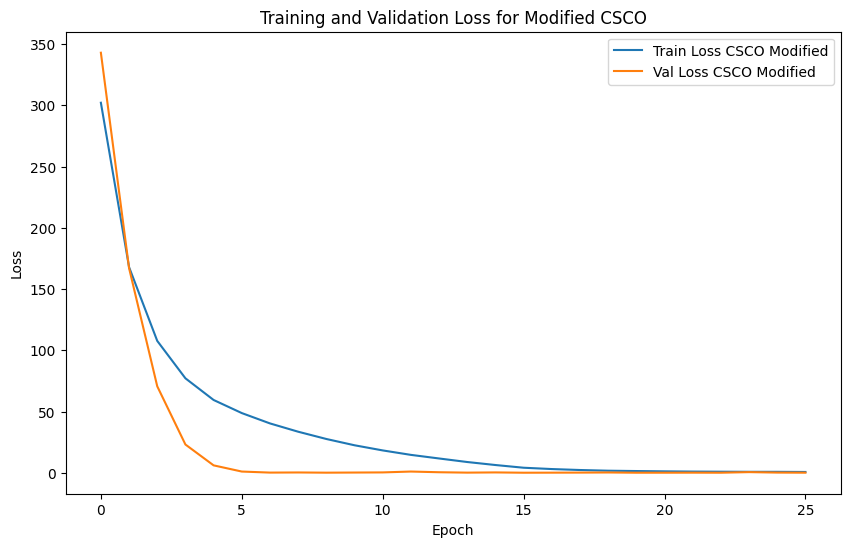

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_csco_mod, label='Train Loss CSCO Modified')
plt.plot(val_losses_csco_mod, label='Val Loss CSCO Modified')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Modified CSCO')
plt.legend()
plt.show()

- Penurunan yang Konsisten: Kedua garis menunjukkan penurunan yang konsisten, yang menunjukkan bahwa model terus belajar dan memperbaiki kinerjanya baik pada data pelatihan maupun data validasi.
- Val Loss Rendah: Val loss yang lebih rendah daripada train loss menunjukkan bahwa model tidak hanya belajar dari data pelatihan tetapi juga generalisasi dengan sangat baik pada data validasi. Ini adalah tanda positif bahwa model bekerja dengan baik dan tidak overfitting.
- Kinerja yang Meningkat: Dibandingkan dengan model baseline, ada peningkatan dalam kinerja model yang dimodifikasi ini, terutama dalam hal penurunan val loss yang lebih signifikan seiring bertambahnya epoch.

## **EVALUATION**

Untuk evaluasi, saya menggunakan 3 metriks yaitu RMSE, MSE, dan MAPE.

1. RMSE (Root Mean Squared Error):
- Mengukur akar rata-rata dari kuadrat kesalahan antara nilai yang diprediksi dan nilai sebenarnya.
- RMSE = sqrt(mean((predicted - actual)^2))

2. MAE (Mean Absolute Error):
- Mengukur rata-rata dari nilai absolut kesalahan antara nilai yang diprediksi dan nilai sebenarnya.
- MAE = mean(abs(predicted - actual))

3. MAPE (Mean Absolute Percentage Error):
- Mengukur rata-rata dari nilai absolut kesalahan dalam bentuk persentase antara nilai yang diprediksi dan nilai sebenarnya.
- MAPE = mean(abs((predicted - actual) / actual)) * 100%

In [69]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_losses.append(loss.item())
            all_preds.append(outputs.numpy())
            all_targets.append(y_batch.numpy())

    test_loss = np.mean(test_losses)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    rmse = np.sqrt(np.mean((all_preds - all_targets)**2))
    mae = np.mean(np.abs(all_preds - all_targets))
    mape = np.mean(np.abs((all_preds - all_targets) / all_targets)) * 100

    return test_loss, rmse, mae, mape

### Baseline architecture

In [70]:
amzn_test_loss, amzn_rmse, amzn_mae, amzn_mape = evaluate_model(baseline_model_amzn, test_loader_amzn, criterion)
print(f'AMZN Baseline Evaluation\nTest Loss: {amzn_test_loss}\nRMSE: {amzn_rmse}\nMAE: {amzn_mae}\nMAPE: {amzn_mape}%')

AMZN Baseline Evaluation
Test Loss: 2705140.472222222
RMSE: 1644.7310791015625
MAE: 1633.2801513671875
MAPE: 94.31226253509521%


Analisis Singkat AMZN:
- RMSE dan MAE Tinggi: Menunjukkan bahwa prediksi model memiliki kesalahan yang cukup besar dibandingkan dengan nilai aktual.
- MAPE Tinggi: MAPE sebesar 94.31% menunjukkan bahwa model memiliki tingkat kesalahan yang sangat tinggi dalam bentuk persentase, yang mengindikasikan model tidak melakukan prediksi yang akurat untuk harga penutupan saham AMZN.

In [71]:
csco_test_loss, csco_rmse, csco_mae, csco_mape = evaluate_model(baseline_model_csco, test_loader_csco, criterion)
print(f'CSCO Baseline Model Evaluation\nTest Loss: {csco_test_loss}\nRMSE: {csco_rmse}\nMAE: {csco_mae}\nMAPE: {csco_mape}%')

CSCO Baseline Model Evaluation
Test Loss: 2.145894080400467
RMSE: 1.4682258367538452
MAE: 1.1104665994644165
MAPE: 2.439115382730961%


Analisis Singkat CSCO:
- RMSE dan MAE Lebih Rendah: Menunjukkan bahwa prediksi model lebih akurat dibandingkan dengan hasil AMZN, tetapi masih ada kesalahan yang cukup signifikan.
- MAPE Rendah: MAPE sebesar 2.44% menunjukkan bahwa model memiliki tingkat kesalahan yang lebih rendah dalam bentuk persentase, mengindikasikan model melakukan prediksi yang lebih akurat untuk harga penutupan saham CSCO dibandingkan AMZN.

1. AMZN: Baseline model menunjukkan performa yang buruk dengan RMSE, MAE, dan MAPE yang sangat tinggi, mengindikasikan model tidak cocok untuk memprediksi harga penutupan saham AMZN.
2. CSCO: Baseline model menunjukkan performa yang lebih baik dibandingkan dengan AMZN, dengan RMSE, MAE, dan MAPE yang lebih rendah, tetapi masih ada ruang untuk perbaikan dalam prediksi.

### Modified architecture

In [74]:
amzn_test_loss_mod, amzn_rmse_mod, amzn_mae_mod, amzn_mape_mod = evaluate_model(modified_model_amzn, test_loader_amzn, criterion)
print(f'AMZN Modifief Model Evaluation\nTest Loss: {amzn_test_loss_mod}\nRMSE: {amzn_rmse_mod}\nMAE: {amzn_mae_mod}\nMAPE: {amzn_mape_mod}%')

AMZN Modifief Model Evaluation
Test Loss: 2184444.597222222
RMSE: 1477.9866943359375
MAE: 1465.2332763671875
MAPE: 84.46296453475952%


Analisis Singkat AMZN:
- Penurunan RMSE dan MAE: Modifikasi arsitektur berhasil mengurangi kesalahan prediksi dibandingkan dengan model baseline.
- Penurunan MAPE: MAPE sebesar 84.46% menunjukkan peningkatan akurasi dalam bentuk persentase, tetapi masih tinggi, mengindikasikan bahwa prediksi model masih memiliki tingkat kesalahan yang signifikan.
- Kesimpulan: Modifikasi arsitektur memberikan perbaikan yang signifikan pada performa model AMZN, meskipun prediksi masih jauh dari akurat.

In [73]:
csco_test_loss_mod, csco_rmse_mod, csco_mae_mod, csco_mape_mod = evaluate_model(modified_model_csco, test_loader_csco, criterion)
print(f'CSCO Modifief Model Evaluation\nTest Loss: {csco_test_loss_mod}\nRMSE: {csco_rmse_mod}\nMAE: {csco_mae_mod}\nMAPE: {csco_mape_mod}%')

CSCO Modifief Model Evaluation
Test Loss: 0.9280179490645727
RMSE: 0.9646240472793579
MAE: 0.6589531898498535
MAPE: 1.4731325209140778%


- Penurunan RMSE dan MAE: Menunjukkan bahwa modifikasi arsitektur berhasil mengurangi kesalahan prediksi dibandingkan dengan baseline.
- Penurunan MAPE: MAPE sebesar 1.47% menunjukkan peningkatan akurasi dalam bentuk persentase, mengindikasikan model yang lebih baik dalam memprediksi harga penutupan saham CSCO.
- Kesimpulan: Modifikasi arsitektur memberikan perbaikan yang signifikan pada performa model CSCO, menghasilkan prediksi yang lebih akurat dibandingkan dengan model baseline.

## **KESIMPULAN**

### AMZN:
Baik model baseline maupun model yang dimodifikasi menunjukkan performa yang buruk dengan RMSE, MAE, dan MAPE yang sangat tinggi.

Modifikasi tidak memberikan perbaikan yang signifikan.

Perlunya eksplorasi lebih lanjut dan tuning tambahan untuk meningkatkan kinerja model.

### CSCO:
Model yang dimodifikasi menunjukkan peningkatan yang signifikan dibandingkan dengan model baseline.

Penurunan yang signifikan pada RMSE, MAE, dan MAPE menunjukkan bahwa modifikasi arsitektur dan hyperparameter berhasil meningkatkan akurasi prediksi.

Modifikasi memberikan hasil yang lebih baik dalam menangkap pola data dan melakukan prediksi yang lebih akurat.

### Analisa penyebab

1. Volatilitas Data:
- AMZN: Data harga penutupan saham AMZN menunjukkan peningkatan yang sangat drastis, terutama setelah tahun 2010. Ini menyebabkan fluktuasi yang besar dan mungkin membuat model sulit untuk menangkap pola dengan baik.
- CSCO: Data harga penutupan saham CSCO lebih stabil dengan fluktuasi yang lebih konsisten sepanjang waktu, membuat model lebih mudah untuk memprediksi pola dalam data.

2. Range Data:
- AMZN: Rentang harga penutupan sangat lebar, mulai dari nilai yang sangat rendah hingga sangat tinggi, yang dapat memperumit proses pelatihan model. Model mungkin kesulitan menyesuaikan prediksi pada berbagai skala harga.
- CSCO: Rentang harga penutupan lebih sempit dan konsisten, memberikan model ruang lingkup yang lebih jelas untuk belajar dan memprediksi dengan lebih akurat.

3. Distribusi Data:
- AMZN: Peningkatan drastis dalam harga saham dapat menyebabkan distribusi data yang sangat miring, mengakibatkan model kesulitan dalam menangkap tren yang stabil.
- CSCO: Distribusi data lebih merata, membantu model dalam menangkap pola dengan lebih baik dan menghasilkan prediksi yang lebih akurat.